<a href="https://colab.research.google.com/github/williambrunos/Pyspark/blob/main/Classification_with_pyspark/aula1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aula 1 - Preparando os Dados**

## **1.1 Apresentação**

## **1.2 Preparando o Ambiente**

### PySpark

PySpark é uma interface para Apache Spark em Python. Ele não apenas permite que você escreva aplicativos Spark usando APIs Python, mas também fornece o *shell* PySpark para analisar interativamente seus dados em um ambiente distribuído. O PySpark oferece suporte à maioria dos recursos do Spark, como Spark SQL, DataFrame, Streaming, MLlib (Machine Learning) e Spark Core.

<center><img src="https://caelum-online-public.s3.amazonaws.com/2273-introducao-spark/01/img-001.png"/></center>

#### **Spark SQL e DataFrame**

Spark SQL é um módulo Spark para processamento de dados estruturados. Ele fornece uma abstração de programação chamada DataFrame e também pode atuar como mecanismo de consulta SQL distribuído.

#### **Spark Streaming**

Executando em cima do Spark, o recurso de *streaming* no Apache Spark possibilita o uso de poderosas aplicações interativas e analíticas em *streaming* e dados históricos, enquanto herda a facilidade de uso do Spark e as características de tolerância a falhas.

#### **Spark MLlib**

Construído sobre o Spark, MLlib é uma biblioteca de aprendizado de máquina escalonável que fornece um conjunto uniforme de APIs de alto nível que ajudam os usuários a criar e ajustar *pipelines* de aprendizado de máquina práticos.

#### **Spark Core**

Spark Core é o mecanismo de execução geral subjacente para a plataforma Spark sobre o qual todas as outras funcionalidades são construídas. Ele fornece um RDD (*Resilient Distributed Dataset*) e recursos de computação na memória.

<font size=2>**Fonte:** [PySpark](https://spark.apache.org/docs/latest/api/python/index.html)</font>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 40.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1cf0624209400f937849b2980a6049f93766393616001bd21b5bb27fd74c1f5c
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


### SparkSession

O ponto de entrada para programar o Spark com a API Dataset e DataFrame.

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet. Para criar uma SparkSession, use o seguinte padrão de construtor:

<font size=2>**Fonte:** [SparkSession](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html)</font>

In [2]:
from pyspark.sql import SparkSession

Criamos uma seção pyspark com SparkSession utilizando
o argumento **local[*]** para indicar que o ambiente local
será o responsável por se comunicar com o ambiente spark

In [3]:
spark = SparkSession.builder.master('local[*]')\
                           .appName('Classification with pyspark')\
                           .getOrCreate()

Se estivéssemos de fato em um ambiente local, poderíamos ver o processamento dos dados por meio da **Spark UI**

In [4]:
spark

## **1.3 Carregamento dos Dados**

In [5]:
from pyspark.sql.types import *

In [6]:
raw_data = spark.read.csv('./dados_clientes.csv', 
                         sep=',', 
                         header=True, 
                         inferSchema=True)

In [7]:
raw_data.show(5)

+---+-----+----------+-------+-----------+---------------+------------+------------------------+-----------+---------------+------------+-----------------+--------------+-------+---------------+------------+------------+----------------+-------------+
| id|Churn|Mais65anos|Conjuge|Dependentes|MesesDeContrato|TelefoneFixo|MaisDeUmaLinhaTelefonica|   Internet|SegurancaOnline|BackupOnline|SeguroDispositivo|SuporteTecnico|TVaCabo|StreamingFilmes|TipoContrato|ContaCorreio| MetodoPagamento|MesesCobrados|
+---+-----+----------+-------+-----------+---------------+------------+------------------------+-----------+---------------+------------+-----------------+--------------+-------+---------------+------------+------------+----------------+-------------+
|  0|  Nao|         0|    Sim|        Nao|              1|         Nao|    SemServicoTelefonico|        DSL|            Nao|         Sim|              Nao|           Nao|    Nao|            Nao| Mensalmente|         Sim|BoletoEletronico|       

Utilizando a função **printSchema**, podemos perceber que a maioria das colunas possui o tipo *string*, o que virá a ser problemático quando utilizarmos modelos de machine learning:

In [8]:
raw_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- Mais65anos: integer (nullable = true)
 |-- Conjuge: string (nullable = true)
 |-- Dependentes: string (nullable = true)
 |-- MesesDeContrato: integer (nullable = true)
 |-- TelefoneFixo: string (nullable = true)
 |-- MaisDeUmaLinhaTelefonica: string (nullable = true)
 |-- Internet: string (nullable = true)
 |-- SegurancaOnline: string (nullable = true)
 |-- BackupOnline: string (nullable = true)
 |-- SeguroDispositivo: string (nullable = true)
 |-- SuporteTecnico: string (nullable = true)
 |-- TVaCabo: string (nullable = true)
 |-- StreamingFilmes: string (nullable = true)
 |-- TipoContrato: string (nullable = true)
 |-- ContaCorreio: string (nullable = true)
 |-- MetodoPagamento: string (nullable = true)
 |-- MesesCobrados: double (nullable = true)



Quantidade de dados:

In [9]:
print(f'{raw_data.count()} data')

10348 data


Verificação do balanceamento das classes da variável **CHURN**

In [10]:
raw_data.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  Sim| 5174|
|  Nao| 5174|
+-----+-----+



## **1.4 Transformando os Dados**

<font size=2>**Fonte:** [Functions](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions)</font>

Primeiramente, façamos o reposisionamento de valores "Sim" e "Não" por valores numéricos 1 e 0, respectivamente. Para isto, precisamos identificar as colunas com realizações binárias.

Identificamos as colunas que possuem o tipo string dos seus dados:

In [11]:
string_columns = [f.name for f in raw_data.schema.fields if isinstance(f.dataType, StringType)]
string_columns

['Churn',
 'Conjuge',
 'Dependentes',
 'TelefoneFixo',
 'MaisDeUmaLinhaTelefonica',
 'Internet',
 'SegurancaOnline',
 'BackupOnline',
 'SeguroDispositivo',
 'SuporteTecnico',
 'TVaCabo',
 'StreamingFilmes',
 'TipoContrato',
 'ContaCorreio',
 'MetodoPagamento']

Iteramos por estas colunas e identificamos quais possuem apenas dois valores únicos, ou três valores únicos mas sendo um deles considerado como valor falso:

In [12]:
for str_col in string_columns:
  print(raw_data.select(str_col).distinct().show())

+-----+
|Churn|
+-----+
|  Sim|
|  Nao|
+-----+

None
+-------+
|Conjuge|
+-------+
|    Sim|
|    Nao|
+-------+

None
+-----------+
|Dependentes|
+-----------+
|        Sim|
|        Nao|
+-----------+

None
+------------+
|TelefoneFixo|
+------------+
|         Sim|
|         Nao|
+------------+

None
+------------------------+
|MaisDeUmaLinhaTelefonica|
+------------------------+
|                     Sim|
|                     Nao|
|    SemServicoTelefonico|
+------------------------+

None
+-----------+
|   Internet|
+-----------+
|FibraOptica|
|        Nao|
|        DSL|
+-----------+

None
+------------------+
|   SegurancaOnline|
+------------------+
|SemServicoInternet|
|               Sim|
|               Nao|
+------------------+

None
+------------------+
|      BackupOnline|
+------------------+
|SemServicoInternet|
|               Sim|
|               Nao|
+------------------+

None
+------------------+
| SeguroDispositivo|
+------------------+
|SemServicoInternet|
|    

Colunas consideradas binárias:

In [13]:
binary_columns = [
    'Churn',
    'Conjuge',
    'Dependentes',
    'TelefoneFixo',
    'MaisDeUmaLinhaTelefonica',
    'SegurancaOnline',
    'BackupOnline',
    'SeguroDispositivo',
    'SuporteTecnico',
    'TVaCabo',
    'StreamingFilmes',
    'ContaCorreio'
]

Importamos a biblioteca de funções do pyspark:

In [14]:
from pyspark.sql import functions as f

In [15]:
f.when?

Criamos uma lista de colunas com regras no estilo:


```SQL
CASE WHEN
```

aplicadas as nossas colunas binárias.



In [16]:
all_columns = [f.when(f.col(c) == 'Sim', 1).otherwise(0).alias(c) for c in binary_columns]

In [17]:
all_columns

[Column<'CASE WHEN (Churn = Sim) THEN 1 ELSE 0 END AS Churn'>,
 Column<'CASE WHEN (Conjuge = Sim) THEN 1 ELSE 0 END AS Conjuge'>,
 Column<'CASE WHEN (Dependentes = Sim) THEN 1 ELSE 0 END AS Dependentes'>,
 Column<'CASE WHEN (TelefoneFixo = Sim) THEN 1 ELSE 0 END AS TelefoneFixo'>,
 Column<'CASE WHEN (MaisDeUmaLinhaTelefonica = Sim) THEN 1 ELSE 0 END AS MaisDeUmaLinhaTelefonica'>,
 Column<'CASE WHEN (SegurancaOnline = Sim) THEN 1 ELSE 0 END AS SegurancaOnline'>,
 Column<'CASE WHEN (BackupOnline = Sim) THEN 1 ELSE 0 END AS BackupOnline'>,
 Column<'CASE WHEN (SeguroDispositivo = Sim) THEN 1 ELSE 0 END AS SeguroDispositivo'>,
 Column<'CASE WHEN (SuporteTecnico = Sim) THEN 1 ELSE 0 END AS SuporteTecnico'>,
 Column<'CASE WHEN (TVaCabo = Sim) THEN 1 ELSE 0 END AS TVaCabo'>,
 Column<'CASE WHEN (StreamingFilmes = Sim) THEN 1 ELSE 0 END AS StreamingFilmes'>,
 Column<'CASE WHEN (ContaCorreio = Sim) THEN 1 ELSE 0 END AS ContaCorreio'>]

Incluindo as colunas transformadas em uma lista contendo todas as colunas dos dados:

In [18]:
for column in reversed(raw_data.columns):
  if column not in binary_columns:
    all_columns.insert(0, column)
all_columns

['id',
 'Mais65anos',
 'MesesDeContrato',
 'Internet',
 'TipoContrato',
 'MetodoPagamento',
 'MesesCobrados',
 Column<'CASE WHEN (Churn = Sim) THEN 1 ELSE 0 END AS Churn'>,
 Column<'CASE WHEN (Conjuge = Sim) THEN 1 ELSE 0 END AS Conjuge'>,
 Column<'CASE WHEN (Dependentes = Sim) THEN 1 ELSE 0 END AS Dependentes'>,
 Column<'CASE WHEN (TelefoneFixo = Sim) THEN 1 ELSE 0 END AS TelefoneFixo'>,
 Column<'CASE WHEN (MaisDeUmaLinhaTelefonica = Sim) THEN 1 ELSE 0 END AS MaisDeUmaLinhaTelefonica'>,
 Column<'CASE WHEN (SegurancaOnline = Sim) THEN 1 ELSE 0 END AS SegurancaOnline'>,
 Column<'CASE WHEN (BackupOnline = Sim) THEN 1 ELSE 0 END AS BackupOnline'>,
 Column<'CASE WHEN (SeguroDispositivo = Sim) THEN 1 ELSE 0 END AS SeguroDispositivo'>,
 Column<'CASE WHEN (SuporteTecnico = Sim) THEN 1 ELSE 0 END AS SuporteTecnico'>,
 Column<'CASE WHEN (TVaCabo = Sim) THEN 1 ELSE 0 END AS TVaCabo'>,
 Column<'CASE WHEN (StreamingFilmes = Sim) THEN 1 ELSE 0 END AS StreamingFilmes'>,
 Column<'CASE WHEN (ContaCorr

Perceba que agora conseguimos binarizar as colunas de dados utilizando um simples select:

In [19]:
raw_data.select(all_columns).show()

+---+----------+---------------+-----------+------------+----------------+-------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+
| id|Mais65anos|MesesDeContrato|   Internet|TipoContrato| MetodoPagamento|MesesCobrados|Churn|Conjuge|Dependentes|TelefoneFixo|MaisDeUmaLinhaTelefonica|SegurancaOnline|BackupOnline|SeguroDispositivo|SuporteTecnico|TVaCabo|StreamingFilmes|ContaCorreio|
+---+----------+---------------+-----------+------------+----------------+-------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+
|  0|         0|              1|        DSL| Mensalmente|BoletoEletronico|        29.85|    0|      1|          0|           0|                       0|              0|           1|                0|             0|      0|              0|      

In [20]:
dataset = raw_data.select(all_columns)

In [21]:
dataset.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Mais65anos: integer (nullable = true)
 |-- MesesDeContrato: integer (nullable = true)
 |-- Internet: string (nullable = true)
 |-- TipoContrato: string (nullable = true)
 |-- MetodoPagamento: string (nullable = true)
 |-- MesesCobrados: double (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- Conjuge: integer (nullable = false)
 |-- Dependentes: integer (nullable = false)
 |-- TelefoneFixo: integer (nullable = false)
 |-- MaisDeUmaLinhaTelefonica: integer (nullable = false)
 |-- SegurancaOnline: integer (nullable = false)
 |-- BackupOnline: integer (nullable = false)
 |-- SeguroDispositivo: integer (nullable = false)
 |-- SuporteTecnico: integer (nullable = false)
 |-- TVaCabo: integer (nullable = false)
 |-- StreamingFilmes: integer (nullable = false)
 |-- ContaCorreio: integer (nullable = false)



Perceba que ainda temos colunas do tipo *string*, mas com realizações com diversos valores possíveis, não sendo apenas valores binários de "Sim" ou "Não"

## **1.5 Criando *Dummies***

Vejamos quais são as colunas de **dataset** que ainda possuem campos classificados como strings:

In [22]:
dataset_str_columns = [f.name for f in dataset.schema.fields if isinstance(f.dataType, StringType)]
dataset_str_columns

['Internet', 'TipoContrato', 'MetodoPagamento']

Agora, veremos os valores únicos de cada coluna:

In [23]:
for dataset_str_col in dataset_str_columns:
  print(dataset.select(dataset_str_col).distinct().show())

+-----------+
|   Internet|
+-----------+
|FibraOptica|
|        Nao|
|        DSL|
+-----------+

None
+------------+
|TipoContrato|
+------------+
|       UmAno|
| Mensalmente|
|    DoisAnos|
+------------+

None
+----------------+
| MetodoPagamento|
+----------------+
|BoletoEletronico|
|   CartaoCredito|
|   DebitoEmConta|
|          Boleto|
+----------------+

None


In [24]:
dataset.select(dataset_str_columns).show()

+-----------+------------+----------------+
|   Internet|TipoContrato| MetodoPagamento|
+-----------+------------+----------------+
|        DSL| Mensalmente|BoletoEletronico|
|        DSL|       UmAno|          Boleto|
|        DSL| Mensalmente|          Boleto|
|        DSL|       UmAno|   DebitoEmConta|
|FibraOptica| Mensalmente|BoletoEletronico|
|FibraOptica| Mensalmente|BoletoEletronico|
|FibraOptica| Mensalmente|   CartaoCredito|
|        DSL| Mensalmente|          Boleto|
|FibraOptica| Mensalmente|BoletoEletronico|
|        DSL|       UmAno|   DebitoEmConta|
|        DSL| Mensalmente|          Boleto|
|        Nao|    DoisAnos|   CartaoCredito|
|FibraOptica|       UmAno|   CartaoCredito|
|FibraOptica| Mensalmente|   DebitoEmConta|
|FibraOptica| Mensalmente|BoletoEletronico|
|FibraOptica|    DoisAnos|   CartaoCredito|
|        Nao|       UmAno|          Boleto|
|FibraOptica|    DoisAnos|   DebitoEmConta|
|        DSL| Mensalmente|   CartaoCredito|
|FibraOptica| Mensalmente|Boleto

Iremos realizar o processamento destas colunas utilizando uma técnica chamada de **one hot encoding**, ou **dummies**. Para isto, utilizaremos a função **pivot** aplicada a datasets agregados, a função **lit** e a função **fill**.

O procedimento geral é:

````Python
dataset.groupby(col_to_group).pivot(col_to_pivot).agg(f.lit(valor_para_presente)).na.fill(valor_para_preencher_dados_ausentes).show()
````

Ou seja: agregamos o dataset pelo id apenas para termos acesso à função pivot (cross tab) utilizando a coluna em que queremos que os valores únicos se tornem colunas, aplicando uma função lit(1) para preencher estas colunas novas com 1 caso o valor único esteja presente na coluna original, deixando como NaN os campos dos valores que não estejam presentes na coluna original. Por fim, utilizamos o fill(0) para preencher como 0 os campos que estejam com valor NaN:

In [25]:
dataset.groupby('id').pivot('Internet').agg(f.lit(1)).na.fill(0).show()

+----+---+-----------+---+
|  id|DSL|FibraOptica|Nao|
+----+---+-----------+---+
|7982|  1|          0|  0|
|9465|  0|          1|  0|
|2122|  1|          0|  0|
|3997|  1|          0|  0|
|6654|  0|          1|  0|
|7880|  0|          1|  0|
|4519|  0|          1|  0|
|6466|  0|          1|  0|
| 496|  1|          0|  0|
|7833|  0|          1|  0|
|1591|  0|          0|  1|
|2866|  0|          1|  0|
|8592|  0|          1|  0|
|1829|  0|          1|  0|
| 463|  0|          1|  0|
|4900|  0|          1|  0|
|4818|  0|          1|  0|
|7554|  1|          0|  0|
|1342|  0|          0|  1|
|5300|  0|          1|  0|
+----+---+-----------+---+
only showing top 20 rows



A forma de interpretar os valores acima: para o id 7982, a realização da coluna **Internet** é **DSL**, pois para este id temos o valor 1 e 0 para as demais realizações consideradas como colunas.

In [26]:
Internet = dataset.groupby('id').pivot('Internet').agg(f.lit(1)).na.fill(0)
TipoContrato = dataset.groupby('id').pivot('TipoContrato').agg(f.lit(1)).na.fill(0)
MetodoPagamento = dataset.groupby('id').pivot('MetodoPagamento').agg(f.lit(1)).na.fill(0)

Perceba que quando realizamos o pivot e utilizamos a técnica de OH Enconding, a coluna original já é removida do dataset

In [27]:
dataset\
  .join(Internet, on='id', how='inner')\
  .join(TipoContrato, on='id', how='inner')\
  .join(MetodoPagamento, on='id', how='inner')\
  .select(
      '*',
      f.col('DSL').alias('Internet_DSL'),
      f.col('FibraOptica').alias('Internet_FibraOptica'),
      f.col('Nao').alias('Internet_Nao'),
      f.col('Mensalmente').alias('TipoContrato_Mensalmente'),
      f.col('UmAno').alias('TipoContrato_UmAno'),
      f.col('DoisAnos').alias('MetodoPagamento_DoisAnos'),
      f.col('DebitoEmConta').alias('MetodoPagamento_DebitoEmConta'),
      f.col('CartaoCredito').alias('MetodoPagamento_CartaoCredito'),
      f.col('BoletoEletronico').alias('MetodoPagamento_BoletoEletronico'),
      f.col('Boleto').alias('MetodoPagamento_Boleto')
  )\
  .drop(
      'Internet', 'TipoContrato', 'MetodoPagamento', 'DSL',
      'FibraOptica', 'Nao', 'Mensalmente', 'UmAno', 'DoisAnos',
      'DebitoEmConta', 'CartaoCredito', 'BoletoEletronico', 'Boleto'
  ).show()

+----+----------+---------------+-----------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+------------+--------------------+------------+------------------------+------------------+------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------+
|  id|Mais65anos|MesesDeContrato|    MesesCobrados|Churn|Conjuge|Dependentes|TelefoneFixo|MaisDeUmaLinhaTelefonica|SegurancaOnline|BackupOnline|SeguroDispositivo|SuporteTecnico|TVaCabo|StreamingFilmes|ContaCorreio|Internet_DSL|Internet_FibraOptica|Internet_Nao|TipoContrato_Mensalmente|TipoContrato_UmAno|MetodoPagamento_DoisAnos|MetodoPagamento_DebitoEmConta|MetodoPagamento_CartaoCredito|MetodoPagamento_BoletoEletronico|MetodoPagamento_Boleto|
+----+----------+---------------+-----------------+-----+-------+-----------+------------+----------------

In [28]:
dataset = dataset\
          .join(Internet, on='id', how='inner')\
          .join(TipoContrato, on='id', how='inner')\
          .join(MetodoPagamento, on='id', how='inner')\
          .select(
              '*',
              f.col('DSL').alias('Internet_DSL'),
              f.col('FibraOptica').alias('Internet_FibraOptica'),
              f.col('Nao').alias('Internet_Nao'),
              f.col('Mensalmente').alias('TipoContrato_Mensalmente'),
              f.col('UmAno').alias('TipoContrato_UmAno'),
              f.col('DoisAnos').alias('MetodoPagamento_DoisAnos'),
              f.col('DebitoEmConta').alias('MetodoPagamento_DebitoEmConta'),
              f.col('CartaoCredito').alias('MetodoPagamento_CartaoCredito'),
              f.col('BoletoEletronico').alias('MetodoPagamento_BoletoEletronico'),
              f.col('Boleto').alias('MetodoPagamento_Boleto')
          )\
          .drop(
              'Internet', 'TipoContrato', 'MetodoPagamento', 'DSL',
              'FibraOptica', 'Nao', 'Mensalmente', 'UmAno', 'DoisAnos',
              'DebitoEmConta', 'CartaoCredito', 'BoletoEletronico', 'Boleto'
          )

In [29]:
dataset.show()

+----+----------+---------------+-----------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+------------+--------------------+------------+------------------------+------------------+------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------+
|  id|Mais65anos|MesesDeContrato|    MesesCobrados|Churn|Conjuge|Dependentes|TelefoneFixo|MaisDeUmaLinhaTelefonica|SegurancaOnline|BackupOnline|SeguroDispositivo|SuporteTecnico|TVaCabo|StreamingFilmes|ContaCorreio|Internet_DSL|Internet_FibraOptica|Internet_Nao|TipoContrato_Mensalmente|TipoContrato_UmAno|MetodoPagamento_DoisAnos|MetodoPagamento_DebitoEmConta|MetodoPagamento_CartaoCredito|MetodoPagamento_BoletoEletronico|MetodoPagamento_Boleto|
+----+----------+---------------+-----------------+-----+-------+-----------+------------+----------------

In [30]:
dataset.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Mais65anos: integer (nullable = true)
 |-- MesesDeContrato: integer (nullable = true)
 |-- MesesCobrados: double (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- Conjuge: integer (nullable = false)
 |-- Dependentes: integer (nullable = false)
 |-- TelefoneFixo: integer (nullable = false)
 |-- MaisDeUmaLinhaTelefonica: integer (nullable = false)
 |-- SegurancaOnline: integer (nullable = false)
 |-- BackupOnline: integer (nullable = false)
 |-- SeguroDispositivo: integer (nullable = false)
 |-- SuporteTecnico: integer (nullable = false)
 |-- TVaCabo: integer (nullable = false)
 |-- StreamingFilmes: integer (nullable = false)
 |-- ContaCorreio: integer (nullable = false)
 |-- Internet_DSL: integer (nullable = true)
 |-- Internet_FibraOptica: integer (nullable = true)
 |-- Internet_Nao: integer (nullable = true)
 |-- TipoContrato_Mensalmente: integer (nullable = true)
 |-- TipoContrato_UmAno: integer (nullable = true)
 |-- MetodoPag

## 2. Criando o Primeiro Modelo  

### 2.1. Regressão Logística

A regressão logística é um método popular para prever uma resposta categórica. É um caso especial de modelos lineares generalizados que prevê a probabilidade dos resultados. Em ``spark.ml``, aregressão logística pode ser usada para prever um resultado binário (dois valores únicos para o target) usando regressão logística binomial ou pode ser usada para prever um resultado multiclasse usando regressão logística multinomial. Use o parâmetro ``family`` para selecionar entre esses dois algoritmos ou deixe-o indefinido e o Spark irá inferir a variante correta.

Em nosso curso, vamos trabalhar com a variável categórica do tipo binomial. O intuito desse algoritmo é modelar a probabilidade de uma determinada classe. Para uma variável alvo com as classes 0 e 1, por exemplo, caso a probabilidade de um registro seja maior que um determinado ponto de corte, o modelo classifica esse registro como 1. Caso seja menor, o modelo classifica como 0.

Fonte: [MLLib classification and regression](https://spark.apache.org/docs/latest/ml-classification-regression.html) | [Binomial LReg](https://spark.apache.org/docs/latest/ml-classification-regression.html#binomial-logistic-regression) | [Multinomial LReg](https://spark.apache.org/docs/latest/ml-classification-regression.html#multinomial-logistic-regression)



In [31]:
dataset.show()

+----+----------+---------------+-----------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+------------+--------------------+------------+------------------------+------------------+------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------+
|  id|Mais65anos|MesesDeContrato|    MesesCobrados|Churn|Conjuge|Dependentes|TelefoneFixo|MaisDeUmaLinhaTelefonica|SegurancaOnline|BackupOnline|SeguroDispositivo|SuporteTecnico|TVaCabo|StreamingFilmes|ContaCorreio|Internet_DSL|Internet_FibraOptica|Internet_Nao|TipoContrato_Mensalmente|TipoContrato_UmAno|MetodoPagamento_DoisAnos|MetodoPagamento_DebitoEmConta|MetodoPagamento_CartaoCredito|MetodoPagamento_BoletoEletronico|MetodoPagamento_Boleto|
+----+----------+---------------+-----------------+-----+-------+-----------+------------+----------------

### 2.2. Vector Assembler

Apesar de termos preparado nosso dados para entrar em um modelo de machine learning convencional, no pyspark ainda precisamos realizar um passo a mais. Por estar preocupado em utilizar apenas o necessário em seus processamentos, precisamos utilizar uma técnica de **vetorização** para deixar os dados de uma forma que o pyspark consiga entender.

In [32]:
from pyspark.ml.feature import VectorAssembler

Renomeamos a coluna target para **label**:

In [33]:
dataset = dataset.withColumnRenamed('Churn', 'label')

Criamos um vetor de características $X$

In [34]:
X = dataset.columns
X.remove('label')
X.remove('id')

Criamos um objeto ``assembler`` que é moldado utilizando o vetor de caracteísticas $X$ e nomeando a coluna output de $features$

In [35]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

Aplicamos o modelo ``assembler`` nos nossos dados e selecionamos apenas **features** e **label** do dataset final

In [36]:
dataset_clean = assembler.transform(dataset).select('features', 'label')

In [37]:
dataset_clean.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                   |label|
+-----------------------------------------------------------------------------------------------------------+-----+
|(24,[1,2,11,12,13,14,17,22],[1.0,45.30540797610398,1.0,1.0,1.0,1.0,1.0,1.0])                               |1    |
|(24,[1,2,3,5,6,8,9,11,12,13,15,17,22],[60.0,103.6142230120257,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|1    |
|(24,[1,2,5,6,10,11,12,13,14,18,23],[12.0,75.85,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                       |0    |
|(24,[1,2,3,5,8,12,13,14,19,21],[69.0,61.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                               |0    |
|(24,[1,2,3,5,6,11,13,15,17,22],[7.0,86.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                 |1    |
|(24,[1,2,5,6,12,13,15,17,22],[14.0,85.03742670311915,1.0,1.0,1.0,1.0,1.

### 2.3. Ajuste e Previsão

In [38]:
SEED = 101

In [39]:
train, test = dataset_clean.randomSplit([0.7, 0.3], seed=SEED)

In [40]:
print(f'Number of training data: {train.count()}')
print(f'Number of test data: {test.count()}')

Number of training data: 7206
Number of test data: 3142


In [41]:
from pyspark.ml.classification import LogisticRegression

In [42]:
lr_model = LogisticRegression()

In [43]:
fitted_model = lr_model.fit(train)

In [44]:
y_prev = fitted_model.transform(test)

In [45]:
y_prev.show(truncate=False)

+------------------------------------------------------------------------------------------------------+-----+------------------------------------------+-----------------------------------------+----------+
|features                                                                                              |label|rawPrediction                             |probability                              |prediction|
+------------------------------------------------------------------------------------------------------+-----+------------------------------------------+-----------------------------------------+----------+
|(24,[0,1,2,3,4,5,6,7,9,10,11,14,18,22],[1.0,55.0,76.25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |0    |[3.0217417975155163,-3.0217417975155163]  |[0.9535467400028285,0.04645325999717154] |0.0       |
|(24,[0,1,2,3,4,5,6,7,13,15,17,22],[1.0,24.0,79.85,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])               |0    |[-0.09221929660763595,0.09221929660763595]|[0.4769615009160580

### 2.4. Métricas

#### 2.4.1 Métricas de Treinamento

In [46]:
summary = fitted_model.summary

In [47]:
print(f'Model Accucary: {summary.accuracy}')
print(f'Model Precision: {summary.precisionByLabel[1]}')
print(f'Model Recall: {summary.recallByLabel[1]}')
print(f'Model F1 score: {summary.fMeasureByLabel()[1]}')

Model Accucary: 0.7849014709963918
Model Precision: 0.7706855791962175
Model Recall: 0.8125173082248685
Model F1 score: 0.7910488002156916


#### 2.4.2 Métricas de Teste

Construiremos do zero uma matriz de confusão para visualizar as métricas anteriores nos dados de teste:

In [48]:
tn = y_prev.select('label', 'prediction').where((f.col('label') == 0) & (f.col('prediction') == 0)).count()
fp = y_prev.select('label', 'prediction').where((f.col('label') == 0) & (f.col('prediction') == 1)).count()
fn = y_prev.select('label', 'prediction').where((f.col('label') == 1) & (f.col('prediction') == 0)).count()
tp = y_prev.select('label', 'prediction').where((f.col('label') == 1) & (f.col('prediction') == 1)).count()


In [49]:
print(f'True Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}\n')

True Negatives: 1179
False Positives: 400
False Negatives: 307
True Positives: 1256



In [50]:
# crio a função que vai receber os dados para serem avaliados
def calcula_mostra_metricas(modelo_lr, df_transform_modelo, normalize=False, percentage=True):
# os passos para montagem da matriz de confusão são os mesmos da aula
  tp = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 1) & (f.col('prediction') == 1)).count()
  tn = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 0) & (f.col('prediction') == 0)).count()
  fp = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 0) & (f.col('prediction') == 1)).count()
  fn = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 1) & (f.col('prediction') == 0)).count()

  valorP = 1
  valorN = 1

  if normalize:
    valorP = tp + fn
    valorN = fp + tn

  if percentage and normalize:
    valorP = valorP / 100
    valorN = valorN / 100

  # ‘s’ será minha string de retorno
  # ela vai coletar e montar minha matriz de confusão
  # e também os valores de acurácia, precisão, recall e F1-score
  s = ''

  # construção da minha string da matriz de confusão  
  s += ' '*20 + 'Previsto\n'
  s += ' '*15 +  'Churn' + ' '*5 + 'Não-Churn\n'
  s += ' '*4 + 'Churn' + ' '*6 +  str(int(tp/valorP)) + ' '*7 + str(int(fn/valorP)) + '\n'
  s += 'Real\n'
  s += ' '*4 + 'Não-Churn' + ' '*2 + str(int(fp/valorN)) +  ' '*7 + str(int(tn/valorN))  + '\n'
  s += '\n'

  # coleto o resumo das métricas com summary
  resumo_lr_treino = modelo_lr.summary

  # adiciono os valores de cada métrica a minha string de retorno
  s += f'Acurácia: {resumo_lr_treino.accuracy}\n'
  s += f'Precisão: {resumo_lr_treino.precisionByLabel[1]}\n'
  s += f'Recall: {resumo_lr_treino.recallByLabel[1]}\n'
  s += f'F1: {resumo_lr_treino.fMeasureByLabel()[1]}\n'

  return s

In [51]:
print(calcula_mostra_metricas(modelo_lr=fitted_model, df_transform_modelo=y_prev))

                    Previsto
               Churn     Não-Churn
    Churn      1256       307
Real
    Não-Churn  400       1179

Acurácia: 0.7849014709963918
Precisão: 0.7706855791962175
Recall: 0.8125173082248685
F1: 0.7910488002156916



![Distribution](https://miro.medium.com/max/700/1*QZsJvZI0MxFTShJqE78nUQ.png)

In [52]:
import matplotlib.pyplot as plt
from matplotlib import cm

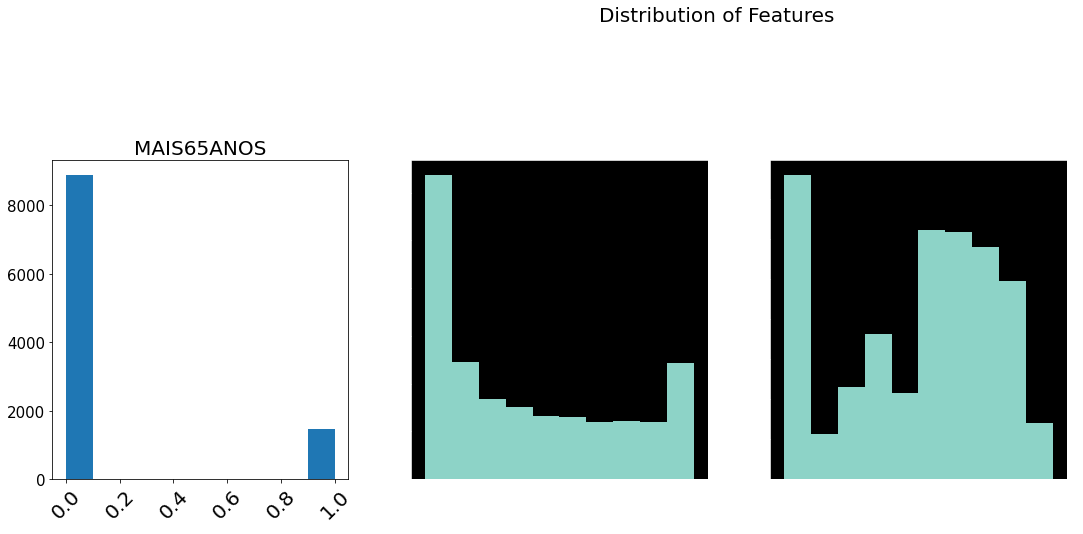

In [53]:
fig = plt.figure(figsize=(20, 20))
st = fig.suptitle('Distribution of Features', fontsize=20, verticalalignment='center') # plot main title

for col, num in zip(raw_data.drop('ID').toPandas().describe().columns, range(1, 20)):
  ax = fig.add_subplot(3, 4, num)
  ax.hist(raw_data.toPandas()[col])
  plt.style.use('dark_background')
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)
plt.tight_layout()
st.set_y(0.95) 
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

## 3.0 Árvores de Decisão

### 3.1 Sobre o Modelo

Árvores de decisão podem ser utilizadas tanto em problemas de classificação quanto em regressão. Conseguem aprender muito bem soluções de problemas multi-classes ou binárias, lidando com features numéricas não normalizadas e categóricas.

Fonte: [Decision Tree Classifier](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html)

Graficamente, a árvore de decisão pode ser representada de forma que cada uma das decisões tomadas no processo possam ser visualizadas. Seus elementos principais são os nós, ramos e folhas. A estrutura da árvore se inicia com um nó inicial, também chamado de raiz. A partir dela são traçadas ramificações, que geram novos nós e o processo se repete para os nós subsequentes até que chegue a uma folha, que se trata de um nó especial que tem a informação da resposta, sendo ela uma categoria ou um valor previsto.

Cada ramo representa uma tomada de decisão a partir de um valor ou de uma categoria das variáveis explicativas, dividindo o conjunto de dados em nós que apresentam dados com características cada vez mais similares entre si.

Em cada nó da árvore, uma feature é analisada e separa o restante dos dados de acordo com um "questionamento" realizado a respeito daquela determinada feature. A acurácia do modelo é mensurada de forma a considerar o quão pura foi uma divisão dos dados feita pelo algoritmo em um determinado nó.

#### 3.1.1 Critério de divisão dos nós

Para conseguir identificar qual o melhor momento em que um nó deve ser dividido em dois ou mais subnós, o algoritmo da árvore de decisão considera alguns critérios. Os dois principais critérios de divisão usados nas árvores de decisão são:

##### Índice Gini

Este índice informa o grau de heterogeneidade dos dados. O objetivo dele é medir a frequência de um elemento aleatório de um nó ser rotulado de maneira incorreta. Em outros termos, esse índice é capaz de medir a impureza de um nó e ele é determinado por meio do seguinte cálculo:

![GINI](https://caelum-online-public.s3.amazonaws.com/2276-spark/03/Aula3-img2.png)

alt text: Fórmula: Gini é igual a 1 menos somatório de i começando em 1 indo até K de P de i ao quadrado.

Onde:

pi representa a frequência relativa das classes em cada um dos nós;
k é o número de classes.
Se o índice Gini for igual a 0, isso indica que o nó é puro. No entanto, se o valor dele se aproxima mais do valor 1, o nó é impuro.

#### Entropia
A ideia básica da entropia é medir a desordem dos dados de um nó por meio da variável classificadora. Assim como o índice de Gini, ela é utilizada para caracterizar a impureza dos dados e pode ser calculada por meio da seguinte fórmula:

![Entropy](https://caelum-online-public.s3.amazonaws.com/2276-spark/03/Aula3-img3.jpg)

alt text: Fórmula: Entropia de S, com S entre parênteses, é igual ao somatório de i iniciando em 1 até c de menos p subscrito i vezes o log 2 de p subscrito i.

Onde:

pi representa a proporção de dados no conjunto de dados (S), pertencentes à classe específica i;
c é o número de classes.